#### Инициализация Keras

Для ускорения обучения на GPU следует настраивать backend под конкретную ОС и модель GPU.

Для ускорения pytorch на Windows и свежей карте от NVidia следует установить вместо обычного pytorch:
```
torch = { version = "^2.7.0+cu128", source = "pytorch-cuda128" }
torchaudio = { version = "^2.7.0+cu128", source = "pytorch-cuda128" }
torchvision = { version = "^0.22.0+cu128", source = "pytorch-cuda128" }
```

Обязательно следует включить репозиторий
```
[[tool.poetry.source]]
name = "pytorch-cuda128"
url = "https://download.pytorch.org/whl/cu128"
priority = "explicit"
```

Для macOS можно использовать jax 0.5.0 (обязательно такая версия) + jax-metal 0.1.1

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"
import keras

print(keras.__version__)

3.9.2


#### Загрузка набора данных для задачи классификации

В данном примере используется фрагмент набора  данных Cats and Dogs Classification Dataset

В наборе данных два класса (всего 24 998 изображений): кошки (12 499 изображения) и собаки (12 499 изображения)

Ссылка: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset

In [2]:
import kagglehub
import os

path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
path = os.path.join(path, "PetImages")

#### Формирование выборок

Для формирования выборок используется устаревший (deprecated) класс ImageDataGenerator

Вместо него рекомендуется использовать image_dataset_from_directory (https://keras.io/api/data_loading/image/)

Для использования image_dataset_from_directory требуется tensorflow

ImageDataGenerator формирует две выборки: обучающую и валидационную (80 на 20).

В каждой выборке изображения масштабируются до размера 224 на 224 пиксела с RGB пространством.

Изображения подгружаются с диска в процессе обучения и валидации модели.

In [3]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

batch_size = 32

data_loader = ImageDataGenerator(validation_split=0.2)

train = data_loader.flow_from_directory(
    directory=path,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary",
    batch_size=batch_size,
    shuffle=True,
    seed=9,
    subset="training",
)

valid = data_loader.flow_from_directory(
    directory=path,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary",
    batch_size=batch_size,
    shuffle=True,
    seed=9,
    subset="validation",
)

train.class_indices

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


{'Cat': 0, 'Dog': 1}

### Пример переноса обучения с использованием предобученной модели VGGNet19

Загрузка предобученной модели VGG19:
- Загрузка весов, полученных при обучении модели на наборе данных ImageNet
- Отключение полносвязанных слоев для адаптации к новой задаче
- Модель будет работать с изображениями 224 на 224 пиксела и RGB пространством

In [4]:
from keras.api.applications.vgg19 import VGG19

vgg19 = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling=None)

vgg19.trainable = False

#### Проектирование архитектуры ИНС на основе предобученной модели

In [5]:
from keras.api.models import Sequential
from keras.api.layers import Dropout, Flatten, Dense

tl_model = Sequential()
tl_model.add(vgg19)

# Добавление собственных слоев (в них будет проводиться обучение для текущей задачи)
tl_model.add(Flatten(name="flattened"))
tl_model.add(Dropout(0.5, name="dropout"))
tl_model.add(Dense(1, activation="sigmoid", name="predictions"))

tl_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flattened (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,049,473 (76.48 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

#### Обучение глубокой модели

Обучение остановлено после второго шага, так как качество модели приемлемое

In [6]:
tl_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

tl_model.fit(x=train, validation_data=valid, epochs=5)

d:\Projects\Python\mai\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 15/625 ━━━━━━━━━━━━━━━━━━━━ 19:08 2s/step - accuracy: 0.6655 - loss: 3.8879

d:\Projects\Python\mai\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 1449s 2s/step - accuracy: 0.9067 - loss: 1.1503 - val_accuracy: 0.9602 - val_loss: 0.5733
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1453s 2s/step - accuracy: 0.9551 - loss: 0.6339 - val_accuracy: 0.9638 - val_loss: 0.5131
Epoch 3/5
  2/625 ━━━━━━━━━━━━━━━━━━━━ 19:54 2s/step - accuracy: 0.9297 - loss: 0.6612

KeyboardInterrupt: 

#### Оценка качества модели

Качество модели - 96.3 %.

In [7]:
tl_model.evaluate(valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.9664 - loss: 0.4611


[0.5092828273773193, 0.9639856219291687]

#### Пример использования обученной модели

Для примера используются случайные изображения из сети Интернет

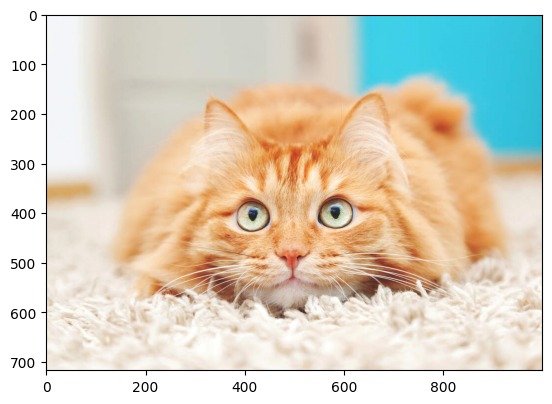

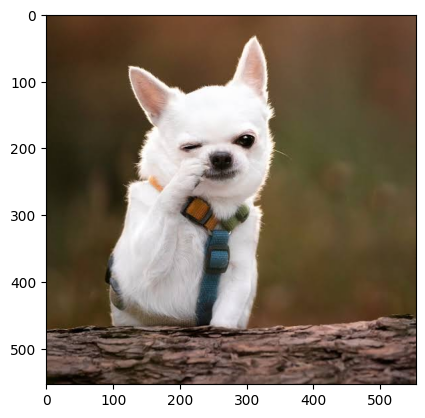

In [8]:
import mahotas as mh
from matplotlib import pyplot as plt

cat = mh.imread("data/-cat.jpg")
plt.imshow(cat)
plt.show()

dog = mh.imread("data/-dog.jpg")
plt.imshow(dog)
plt.show()

In [9]:
resized_cat = mh.resize.resize_rgb_to(cat, (224, 224))

resized_dog = mh.resize.resize_rgb_to(dog, (224, 224))
resized_dog.shape

(224, 224, 3)

In [10]:
results = [
    1 if tl_model.predict(item.reshape(1, 224, 224, 3).astype("float32")) > 0.5 else 0
    for item in [resized_cat, resized_dog]
]

for result in results:
    display(result, list(valid.class_indices.keys())[list(valid.class_indices.values()).index(result)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


0

'Cat'

1

'Dog'